In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import matplotlib.patches as mpatches
import datetime as dt
import scipy.stats as stats

# Merge excel files
path = "datasets/output/data_cleaned.xlsx"

dataset_df = pd.read_excel(path)

In [2]:
# Only take necessary columns
dataset_df = dataset_df[['CCAN', 'DATE', 'Status', 'TOT NET', 'Net Investment', '31-60', '61-90', '91-120', '120+', 'Past Due', 'Aging', 'Country']]

dataset_df.count()

CCAN              140236
DATE              140236
Status            140236
TOT NET           140236
Net Investment    140236
31-60             140236
61-90             140236
91-120            140236
120+              140236
Past Due          140236
Aging             140236
Country           140236
dtype: int64

In [3]:
# Count number of months as input
input_files = os.listdir("datasets/input/")
input_count = len(input_files)

# Create extra columns, needed for later analysis
extended_dataset_df = dataset_df
extended_dataset_df["Past Due AVG MLN"] = round(extended_dataset_df["Past Due"] / input_count / 1000000, 2)
extended_dataset_df["Net Investment AVG MLN"] = round(extended_dataset_df["Net Investment"] / input_count / 1000000, 2)
extended_dataset_df["Year"] = pd.DatetimeIndex(extended_dataset_df['DATE']).year
extended_dataset_df["Past Due MLN"] = round(extended_dataset_df["Past Due"] / 1000000, 2)
extended_dataset_df["TOT NET MLN"] = round(extended_dataset_df["TOT NET"] / 1000000, 2)
extended_dataset_df["Net Investment AVG YEAR MLN"] = round(extended_dataset_df["Net Investment"] / 12 / 1000000, 2)
extended_dataset_df["Net Investment MLN"] = round(extended_dataset_df["Net Investment"] / 1000000, 2)

extended_dataset_df.head()

,CCAN,DATE,Status,TOT NET,Net Investment,31-60,61-90,91-120,120+,Past Due,Aging,Country,Past Due AVG MLN,Net Investment AVG MLN,Year,Past Due MLN,TOT NET MLN,Net Investment AVG YEAR MLN,Net Investment MLN
0,320023,2016-01-31,LEGAL,1.534098e+09,15555962.86,0.00,0.00,0.00,15555962.86,15555962.86,120+,MEXICO,0.20,0.20,2016,15.56,1534.1,1.30,15.56
1,315112,2016-01-31,LEGAL,1.534098e+09,3265682.10,0.00,0.00,0.00,3265682.10,3265682.10,120+,MEXICO,0.04,0.04,2016,3.27,1534.1,0.27,3.27
2,309348,2016-01-31,REGULAR,1.534098e+09,3006305.90,0.00,356160.13,1678580.73,971565.04,3006305.90,120+,COSTA RICA,0.04,0.04,2016,3.01,1534.1,0.25,3.01
3,320248,2016-01-31,REGULAR,1.534098e+09,2874745.56,0.00,1191181.78,1683563.78,0.00,2874745.56,91-120,MEXICO,0.04,0.04,2016,2.87,1534.1,0.24,2.87
4,308247,2016-01-31,REGULAR,1.534098e+09,2556572.66,729813.89,0.00,1826758.77,0.00,2556572.66,91-120,GUATEMALA,0.03,0.03,2016,2.56,1534.1,0.21,2.56


In [4]:
# Get dataset only Legal Customers
ext_dat_LEGAL_df = extended_dataset_df.loc[(extended_dataset_df["Status"] == 'LEGAL')&(extended_dataset_df["Country"]!='VENEZUELA')].dropna()
# Calculate average Past Due in million USD per month per country
country_count_legal = ext_dat_LEGAL_df.groupby(["Country","CCAN"])["Net Investment"].mean()
prueba=pd.DataFrame(country_count_legal)
prueba.reset_index(inplace=True)
prueba

,Country,CCAN,Net Investment
0,BELICE,308932,1.233804e+04
1,COLOMBIA,18645,9.454767e+04
2,COLOMBIA,18647,3.100079e+04
3,COLOMBIA,18758,1.048620e+04
4,COLOMBIA,18792,1.734914e+04
...,...,...,...
1170,REPUBLICA DOMINICANA,316137,5.948492e+04
1171,REPUBLICA DOMINICANA,316300,9.571780e+04
1172,REPUBLICA DOMINICANA,316978,1.847610e+06
1173,REPUBLICA DOMINICANA,320022,2.406551e+06


In [5]:
#Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers

list_1=prueba['Country'].unique()
country_list=list_1.tolist()

print(' Legal by Country:')
print('------------------------------')

for country in country_list:
    print(f'Country: {country}')
    pais = prueba[prueba['Country'] == country]
    quartiles = pais['Net Investment'].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f"The lower quartile of Net Investment for {country} is: {lowerq}")
    print(f"The upper quartile of Net Investment for {country}is: {upperq}")
    print(f"The interquartile range of Net Investment for {country} is: {iqr}")
    print(f"The the median of Net Investment for {country}is: {quartiles[0.5]} ")
    
    # Determine outliers using upper and lower bounds
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"Maximum Value {prueba[prueba['Country'] == country]['Net Investment'].max()}")
    print(f"Min Value {prueba[prueba['Country'] == country]['Net Investment'].min()}")
    if upper_bound > prueba[prueba['Country'] == country]['Net Investment'].max():
        print("Since Maximun value is less than upper bound, there are no outliers in the upper level")
    else:
        print("Since Maximun value is higher than upper bound, there are possible outliers in the upper level")
    if lower_bound < prueba[prueba['Country'] == country]['Net Investment'].min():
        print("Since Minimum value is higher than lower bound, there are no outliers in the lower level")
    else:
        print("Since Minimun value is less than lower bound, there are possible outliers in the lower level")
    
    print('*********************************')  

 Legal by Country:
------------------------------
Country: BELICE
The lower quartile of Net Investment for BELICE is: 12338.04
The upper quartile of Net Investment for BELICEis: 12338.04
The interquartile range of Net Investment for BELICE is: 0.0
The the median of Net Investment for BELICEis: 12338.04 
Values below 12338.04 could be outliers.
Values above 12338.04 could be outliers.
Maximum Value 12338.04
Min Value 12338.04
Since Maximun value is higher than upper bound, there are possible outliers in the upper level
Since Minimun value is less than lower bound, there are possible outliers in the lower level
*********************************
Country: COLOMBIA
The lower quartile of Net Investment for COLOMBIA is: 15853.853687796824
The upper quartile of Net Investment for COLOMBIAis: 95446.56413256787
The interquartile range of Net Investment for COLOMBIA is: 79592.71044477104
The the median of Net Investment for COLOMBIAis: 37797.77078788585 
Values below -103535.21197935974 could be 

In [6]:
prueba = prueba.loc[(prueba["Country"]!='ST VINCENT')].dropna()

prueba["Net Investment MLN"] = round(prueba["Net Investment"] / 1000, 2)
prueba

,Country,CCAN,Net Investment,Net Investment MLN
0,BELICE,308932,1.233804e+04,12.34
1,COLOMBIA,18645,9.454767e+04,94.55
2,COLOMBIA,18647,3.100079e+04,31.00
3,COLOMBIA,18758,1.048620e+04,10.49
4,COLOMBIA,18792,1.734914e+04,17.35
...,...,...,...,...
1169,REPUBLICA DOMINICANA,1319474,2.704125e+05,270.41
1170,REPUBLICA DOMINICANA,316137,5.948492e+04,59.48
1171,REPUBLICA DOMINICANA,316300,9.571780e+04,95.72
1172,REPUBLICA DOMINICANA,316978,1.847610e+06,1847.61


<Figure size 21600x720 with 0 Axes>

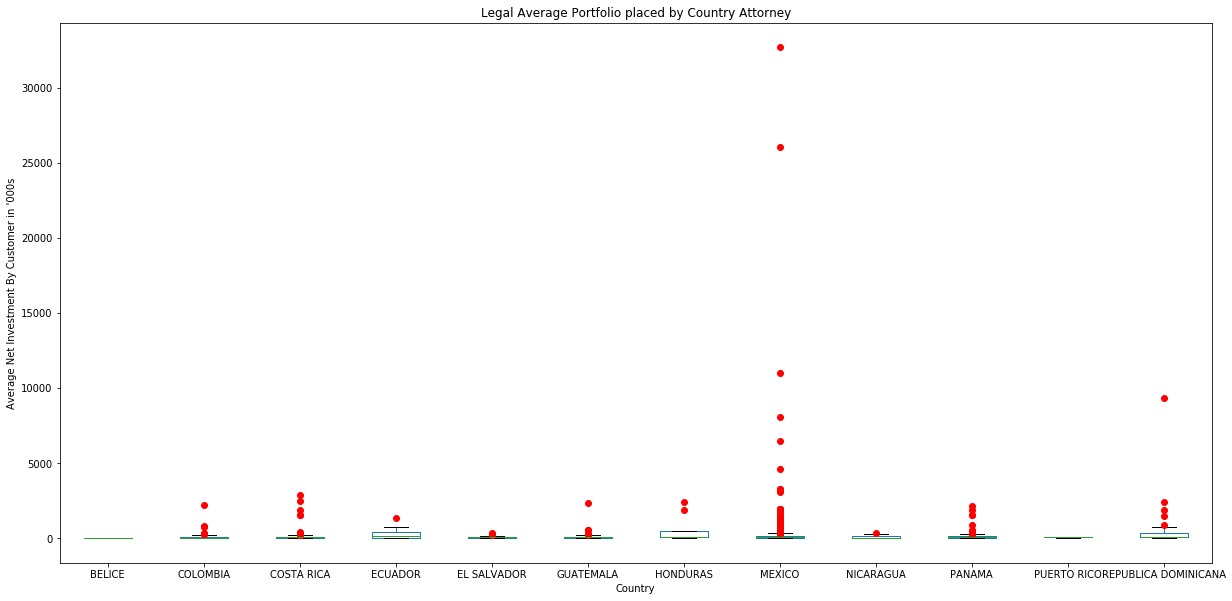

In [7]:
plt.figure(figsize=(300,10))

prueba.boxplot(by='Country', column=["Net Investment MLN"], grid=False, showfliers=True, sym='r',figsize=(20,10))
plt.ylabel("Average Net Investment By Customer in '000s")
plt.title('Legal Average Portfolio placed by Country Attorney')
plt.suptitle(None)

plt.show()

In [8]:

prueba = prueba.drop(prueba[prueba["Net Investment MLN"]>2000].index)
prueba

,Country,CCAN,Net Investment,Net Investment MLN
0,BELICE,308932,1.233804e+04,12.34
1,COLOMBIA,18645,9.454767e+04,94.55
2,COLOMBIA,18647,3.100079e+04,31.00
3,COLOMBIA,18758,1.048620e+04,10.49
4,COLOMBIA,18792,1.734914e+04,17.35
...,...,...,...,...
1168,REPUBLICA DOMINICANA,1037336,7.127391e+04,71.27
1169,REPUBLICA DOMINICANA,1319474,2.704125e+05,270.41
1170,REPUBLICA DOMINICANA,316137,5.948492e+04,59.48
1171,REPUBLICA DOMINICANA,316300,9.571780e+04,95.72


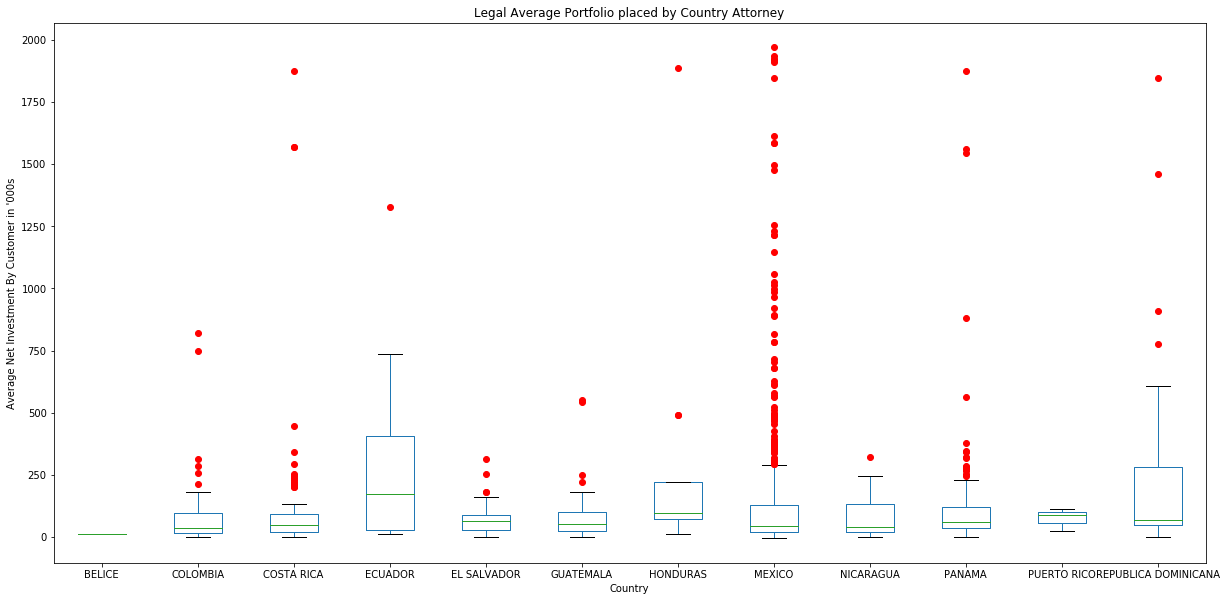

In [9]:
#plt.figure(figsize=(300,10))

prueba.boxplot(by='Country', column=["Net Investment MLN"], grid=False, showfliers=True, sym='r',figsize=(20,10))
plt.ylabel("Average Net Investment By Customer in '000s")
plt.title('Legal Average Portfolio placed by Country Attorney')
plt.suptitle(None)

plt.show()

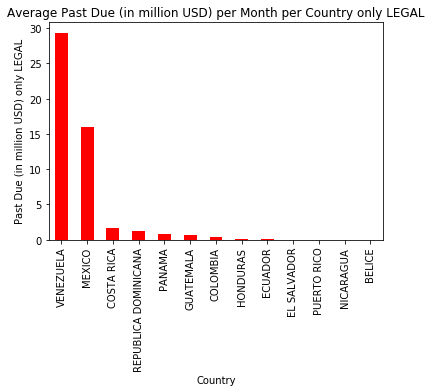

In [10]:
# Get dataset only Legal Customers
ext_dat_LEGAL_df = extended_dataset_df.loc[(extended_dataset_df["Status"] == 'LEGAL')&(extended_dataset_df["Aging"]!='1-30')].dropna()
# Calculate average Past Due in million USD per month per country
country_count_legal = ext_dat_LEGAL_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count_legal = country_count_legal.sort_values(ascending=False)
country_count_legal.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD) only LEGAL")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country only LEGAL")
plt.show()

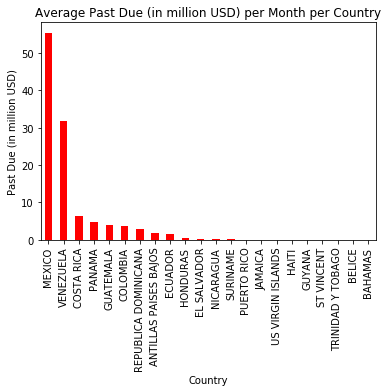

In [11]:
# Calculate average Past Due in million USD per month per country
country_count = extended_dataset_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count = country_count.sort_values(ascending=False)
country_count.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country")
plt.show()

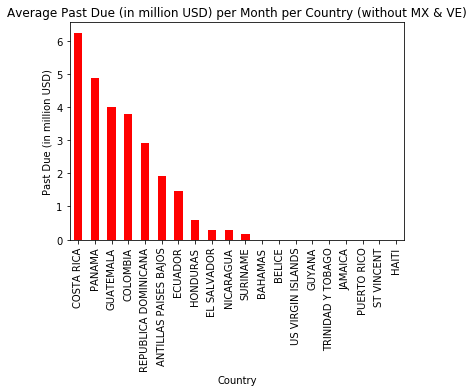

In [12]:
# Get dataset without Mexico and Venezuela
ext_dat_nomx_df = extended_dataset_df.loc[(extended_dataset_df["Country"] != 'MEXICO')].dropna()
ext_dat_nomx_df = ext_dat_nomx_df.loc[(ext_dat_nomx_df["Country"] != 'VENEZUELA')].dropna()

# Calculate average Past Due in USD per month per country
country_count2 = ext_dat_nomx_df.groupby(["Country"])["Past Due AVG MLN"].sum()
country_count2 = country_count2.sort_values(ascending=False)
country_count2.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country (without MX & VE)")
plt.show()                                        
                                          

In [13]:
def year_overview(yearyear):
    year_df = extended_dataset_df.loc[(extended_dataset_df["Year"] == yearyear)].dropna()
    # Group by customer
    customer_gbdf = year_df.groupby(['CCAN'])

    # Past Due Count
    cust_pd_count = customer_gbdf['Net Investment AVG YEAR MLN'].sum()
    cust_country = customer_gbdf['Country'].unique().str[0]

    #summary table
    sum_cust_pd_df = pd.DataFrame({
            "Net Investment AVG MLN":cust_pd_count,
            "Country":cust_country})
    sum_cust_pd_df.index.name="CCAN"

    sum_cust_pd_df = sum_cust_pd_df.reset_index()
    # Filter top four countries out of DF
    sum_cust_pd_df = sum_cust_pd_df.loc[((sum_cust_pd_df["Country"] == 'MEXICO') | (sum_cust_pd_df["Country"] == 'VENEZUELA')
                                         | (sum_cust_pd_df["Country"] == 'COSTA RICA') | (sum_cust_pd_df["Country"] == 'PANAMA')
                                        )].dropna()


    # get dataframe sorted by life Expectancy in each continent 
    top_net_inv = sum_cust_pd_df.groupby(["Country"]).apply(lambda x: x.sort_values(["Net Investment AVG MLN"], ascending = False)).reset_index(drop=True)
    # select top N rows within each continent
    n_clients = 2
    top_net_inv = top_net_inv.groupby('Country').head(n_clients)

    
    objects = top_net_inv['CCAN']
    x_value = np.arange(len(objects))
    performance = top_net_inv['Net Investment AVG MLN']

    # plot bar
    plt.bar(x_value, performance, align='center', color=('#FFC30F', '#FFC30F', '#FF5733', '#FF5733', 
                                                         '#c70039', '#c70039', '#581845', '#581845'))
    plt.xticks(x_value, objects)

    col1 = mpatches.Patch(color='#FFC30F', label='Costa Rica')
    col2 = mpatches.Patch(color='#FF5733', label='Mexico')
    col3 = mpatches.Patch(color='#c70039', label='Panama')
    col4 = mpatches.Patch(color='#581845', label='Venezuela')

    plt.legend(handles=[col1, col2, col3, col4])
    plt.xlabel('CCAN')
    plt.ylabel('Net Investment per month (in million USD)')
    plt.title('Top 2 clients in Net Inv Avg (mln USD) per top 4 country in ' + str(yearyear))

    return plt.show(), print(top_net_inv)
    

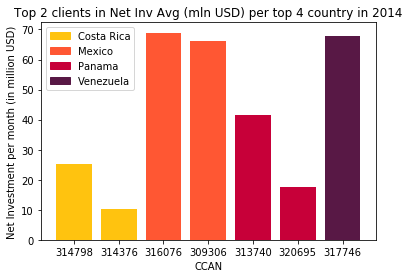

        CCAN  Net Investment AVG MLN     Country
0     314798                   25.11  COSTA RICA
1     314376                   10.09  COSTA RICA
176   316076                   68.93      MEXICO
177   309306                   66.31      MEXICO
1292  313740                   41.51      PANAMA
1293  320695                   17.57      PANAMA
1463  317746                   67.91   VENEZUELA


(None, None)

In [14]:
year_overview(2014)


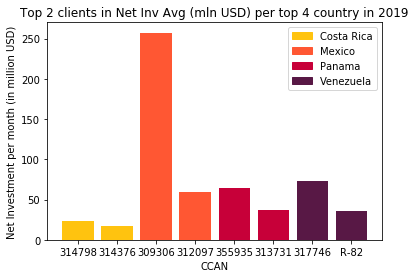

        CCAN  Net Investment AVG MLN     Country
0     314798                   23.86  COSTA RICA
1     314376                   17.54  COSTA RICA
260   309306                  257.28      MEXICO
261   312097                   58.77      MEXICO
1283  355935                   64.65      PANAMA
1284  313731                   37.08      PANAMA
1558  317746                   73.32   VENEZUELA
1559    R-82                   35.73   VENEZUELA


(None, None)

In [15]:
year_overview(2019)

In [16]:
path1 = "datasets/output/exchange_rates.csv"
exchange_rates_df = pd.read_csv(path1)
exchange_rates_df

,Unnamed: 0,Date,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,0,2012-01-31,12.980045,506.324967,1807.124560,7.785415
1,1,2012-02-28,12.840447,509.358967,1783.259039,7.746895
2,2,2012-03-31,12.710813,506.019490,1763.764386,7.731204
3,3,2012-04-30,12.993272,503.864003,1760.796136,7.777389
4,4,2012-05-31,14.241763,501.678065,1827.441649,7.804439
...,...,...,...,...,...,...
99,99,2020-04-30,24.230800,567.972162,3896.741039,7.718042
100,100,2020-05-31,22.185207,569.256516,3704.524858,7.686415
101,101,2020-06-30,23.019400,579.835166,3742.764903,7.700776
102,102,2020-07-31,22.283049,583.939167,3742.575980,7.711148


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          212.32    1475.27      14.391942
2014-05-31           74.57    1586.63       4.699899
2014-06-30           94.45    1525.45       6.191616
2014-07-31           86.18    1597.91       5.393295
2014-08-31          105.76    1535.10       6.889453
...                    ...        ...            ...
2020-03-31          144.86    1144.26      12.659710
2020-04-30          148.14    1136.23      13.037853
2020-05-31          163.84    1159.34      14.132179
2020-06-30          158.56    1183.65      13.395852
2020-07-31          150.98    1166.09      12.947543

[76 rows x 3 columns]


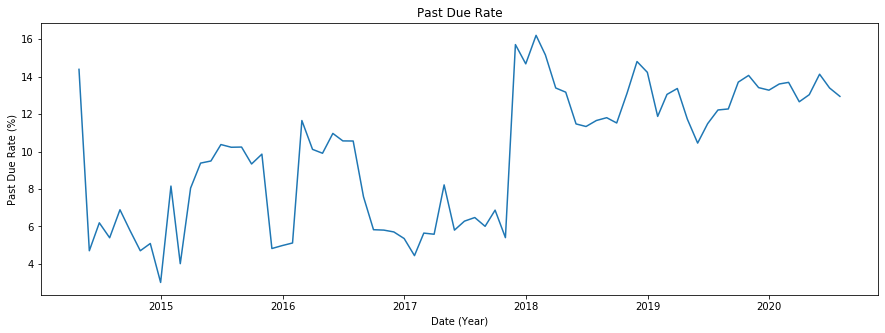

In [17]:
#Groupby 'Date' and making the operations to obtain the Past Due Rate for all the countries
new_extended_dataset_df = extended_dataset_df.groupby(['DATE'])

#SUmmary statistics
sum_past_due = new_extended_dataset_df['Past Due MLN'].sum()
total_net = new_extended_dataset_df['TOT NET MLN'].unique().str[0]

#Summary table
past_due_index = pd.DataFrame({
    "Total Past Due": sum_past_due,
    "Total Net": total_net,
    "Past Due Rate": (sum_past_due / total_net) * 100    
})
print(past_due_index)

#Plotting values 
fig = plt.figure(figsize=(15,5))
y = past_due_index['Past Due Rate']
x = past_due_index.index
plt.title('Past Due Rate')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          156.46    1475.27      10.605516
2014-05-31           41.35    1586.63       2.606153
2014-06-30           67.29    1525.45       4.411157
2014-07-31           41.83    1597.91       2.617794
2014-08-31           53.35    1535.10       3.475344
...                    ...        ...            ...
2020-03-31           34.29    1144.26       2.996697
2020-04-30           31.93    1136.23       2.810170
2020-05-31           37.25    1159.34       3.213035
2020-06-30           33.37    1183.65       2.819246
2020-07-31           29.85    1166.09       2.559837

[76 rows x 3 columns]


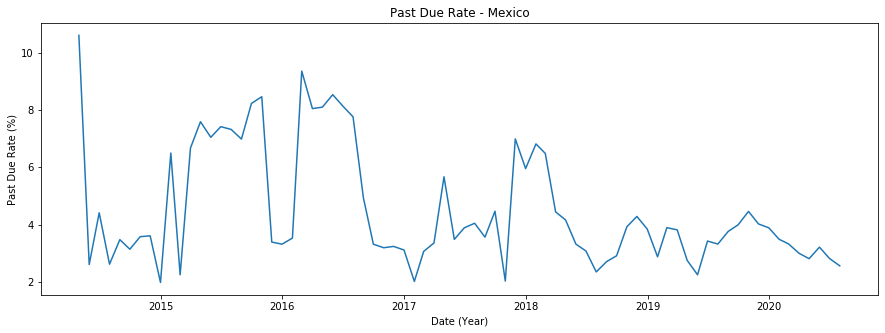

In [18]:
#Groupby 'Date' and making the statistics to obtain the Past Due Rate for Mexico
mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])
sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]

#Summary table
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
    
})
print(past_due_index_mx)

#Plotting values 
fig = plt.figure(figsize=(15,5))
y = past_due_index_mx['Past Due Rate']
x = past_due_index_mx.index
plt.title('Past Due Rate - Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.show()

            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30           55.86    1475.27       3.786426
2014-05-31           33.22    1586.63       2.093746
2014-06-30           27.16    1525.45       1.780458
2014-07-31           44.35    1597.91       2.775500
2014-08-31           52.41    1535.10       3.414110
...                    ...        ...            ...
2020-03-31          110.57    1144.26       9.663014
2020-04-30          116.21    1136.23      10.227683
2020-05-31          126.59    1159.34      10.919144
2020-06-30          125.19    1183.65      10.576606
2020-07-31          121.13    1166.09      10.387706

[76 rows x 3 columns]


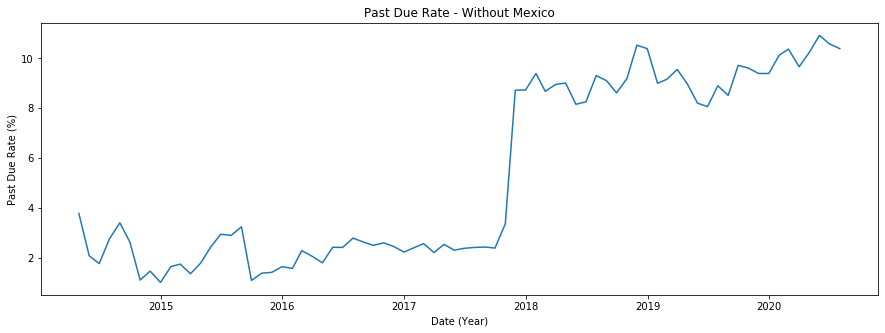

In [19]:
#Groupby 'Date' and making the statistics to obtain the Past Due Rate without Mexico
without_mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] != 'MEXICO')]
without_mexico_extended_dataset_df = without_mexico_df.groupby(['DATE'])
sum_past_due_mx = without_mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = without_mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]

#Summary table
without_mex_past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100   
})
print(without_mex_past_due_index_mx)

#Plotting values
fig = plt.figure(figsize=(15,5))
y = without_mex_past_due_index_mx['Past Due Rate']
x = without_mex_past_due_index_mx.index
plt.title('Past Due Rate - Without Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.show()

### Past Due Rate vs. USD to MXN Exchange Rate

In [20]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_df = past_due_index
exc_pastdue_df.reset_index(level=0, inplace=True)
exc_pastdue_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].astype(str)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].str[:-3]

exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,212.32,1475.27,14.391942
1,2014-05,74.57,1586.63,4.699899
2,2014-06,94.45,1525.45,6.191616
3,2014-07,86.18,1597.91,5.393295
4,2014-08,105.76,1535.10,6.889453


In [21]:
# Getting Exchange Rate data
exchange_rate_path = "datasets/output/exchange_rates.csv"
exchange_rate_df = pd.read_csv(exchange_rate_path)
del exchange_rate_df['Unnamed: 0']
exchange_rate_df['Date'] = exchange_rate_df['Date'].str[:-3]
exchange_rate_df.head()

,Date,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2012-01,12.980045,506.324967,1807.124560,7.785415
1,2012-02,12.840447,509.358967,1783.259039,7.746895
2,2012-03,12.710813,506.019490,1763.764386,7.731204
3,2012-04,12.993272,503.864003,1760.796136,7.777389
4,2012-05,14.241763,501.678065,1827.441649,7.804439


In [22]:
# Merge both DataFrames
exc_pastdue_df = exc_pastdue_df.merge(exchange_rate_df)
exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,212.32,1475.27,14.391942,13.08806,548.222400,1936.044992,7.732037
1,2014-05,74.57,1586.63,4.699899,12.85641,552.406904,1898.106683,7.778281
2,2014-06,94.45,1525.45,6.191616,12.97124,544.414998,1879.213333,7.775380
3,2014-07,86.18,1597.91,5.393295,13.19951,538.396306,1876.443325,7.810024
4,2014-08,105.76,1535.10,6.889453,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is 0.46
The r-squared is: 0.21536568886207355


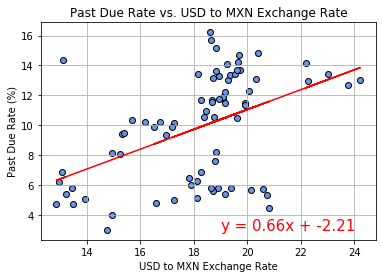

In [23]:
# Scatter plot
x_values = exc_pastdue_df['MXN Exhange Rate']
y_values = exc_pastdue_df['Past Due Rate'] 
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to MXN Exchange Rate without Mexico

In [24]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_wo_mx_df = without_mex_past_due_index_mx
exc_pastdue_wo_mx_df.reset_index(level=0, inplace=True)
exc_pastdue_wo_mx_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_wo_mx_df['Date'] = exc_pastdue_wo_mx_df['Date'].astype(str)
exc_pastdue_wo_mx_df['Date'] = exc_pastdue_wo_mx_df['Date'].str[:-3]

exc_pastdue_wo_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,55.86,1475.27,3.786426
1,2014-05,33.22,1586.63,2.093746
2,2014-06,27.16,1525.45,1.780458
3,2014-07,44.35,1597.91,2.775500
4,2014-08,52.41,1535.10,3.414110


In [25]:
# Merge both DataFrames
exc_pastdue_wo_df = exc_pastdue_wo_mx_df.merge(exchange_rate_df)
exc_pastdue_wo_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,55.86,1475.27,3.786426,13.08806,548.222400,1936.044992,7.732037
1,2014-05,33.22,1586.63,2.093746,12.85641,552.406904,1898.106683,7.778281
2,2014-06,27.16,1525.45,1.780458,12.97124,544.414998,1879.213333,7.775380
3,2014-07,44.35,1597.91,2.775500,13.19951,538.396306,1876.443325,7.810024
4,2014-08,52.41,1535.10,3.414110,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is 0.63
The r-squared is: 0.39317929306685284


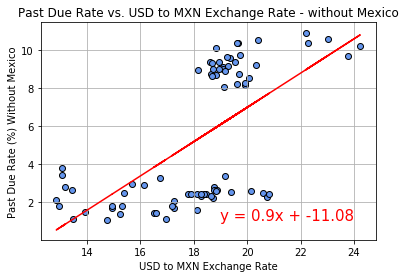

In [26]:
# Scatter plot
x_values = exc_pastdue_wo_df['MXN Exhange Rate']
y_values = exc_pastdue_wo_df['Past Due Rate'] 
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate - without Mexico')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%) Without Mexico')
plt.grid()
plt.show()

## Past Due Rate vs. USD to MXN Exchange Rate Mexico


In [27]:
# Merge both DataFrames
mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])

sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
    
})

exc_pastdue_mx_df = past_due_index_mx
exc_pastdue_mx_df.reset_index(level=0, inplace=True)
exc_pastdue_mx_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].astype(str)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].str[:-3]

exc_pastdue_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,156.46,1475.27,10.605516
1,2014-05,41.35,1586.63,2.606153
2,2014-06,67.29,1525.45,4.411157
3,2014-07,41.83,1597.91,2.617794
4,2014-08,53.35,1535.10,3.475344


In [28]:
exc_pastdue_mx_df = exc_pastdue_mx_df.merge(exchange_rate_df)
exc_pastdue_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,156.46,1475.27,10.605516,13.08806,548.222400,1936.044992,7.732037
1,2014-05,41.35,1586.63,2.606153,12.85641,552.406904,1898.106683,7.778281
2,2014-06,67.29,1525.45,4.411157,12.97124,544.414998,1879.213333,7.775380
3,2014-07,41.83,1597.91,2.617794,13.19951,538.396306,1876.443325,7.810024
4,2014-08,53.35,1535.10,3.475344,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is -0.29
The r-squared is: 0.08406676559808879


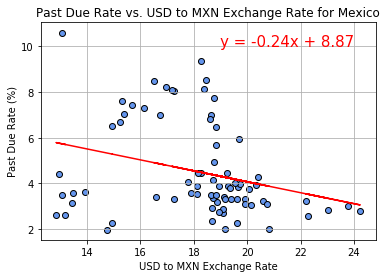

In [29]:
# Scatter plot
x_values = exc_pastdue_mx_df['MXN Exhange Rate']
y_values = exc_pastdue_mx_df['Past Due Rate']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, 10), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate for Mexico')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to CRC Exchange Rate for Costa Rica

In [30]:
costa_rica_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'COSTA RICA')]
costa_rica_extended_dataset_df = costa_rica_df.groupby(['DATE'])

sum_past_due_cr = costa_rica_extended_dataset_df['Past Due MLN'].sum()
total_net_cr = costa_rica_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_cr = pd.DataFrame({
    "Total Past Due": sum_past_due_cr,
    "Total Net": total_net_cr,
    "Past Due Rate": (sum_past_due_cr / total_net_cr) * 100
    
})

exc_pastdue_cr_df = past_due_index_cr
exc_pastdue_cr_df.reset_index(level=0, inplace=True)
exc_pastdue_cr_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_cr_df['Date'] = exc_pastdue_cr_df['Date'].astype(str)
exc_pastdue_cr_df['Date'] = exc_pastdue_cr_df['Date'].str[:-3]

exc_pastdue_cr_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,3.55,1475.27,0.240634
1,2014-05,2.95,1586.63,0.185929
2,2014-06,1.95,1525.45,0.127831
3,2014-07,2.56,1597.91,0.160209
4,2014-08,1.46,1535.10,0.095108


In [31]:
# Merge both DataFrames
exc_pastdue_cr_df = exc_pastdue_cr_df.merge(exchange_rate_df)
exc_pastdue_cr_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,3.55,1475.27,0.240634,13.08806,548.222400,1936.044992,7.732037
1,2014-05,2.95,1586.63,0.185929,12.85641,552.406904,1898.106683,7.778281
2,2014-06,1.95,1525.45,0.127831,12.97124,544.414998,1879.213333,7.775380
3,2014-07,2.56,1597.91,0.160209,13.19951,538.396306,1876.443325,7.810024
4,2014-08,1.46,1535.10,0.095108,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is 0.74
The r-squared is: 0.5424182021010845


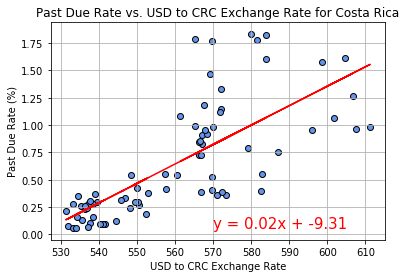

In [32]:
# Scatter plot
x_values = exc_pastdue_cr_df['CRC Exhange Rate']
y_values = exc_pastdue_cr_df['Past Due Rate']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (570, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to CRC Exchange Rate for Costa Rica')
plt.xlabel('USD to CRC Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to COP Exchange Rate for Colombia

In [33]:
colombia_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'COLOMBIA')]
colombia_extended_dataset_df = colombia_df.groupby(['DATE'])
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
sum_past_due_co = colombia_extended_dataset_df['Past Due MLN'].sum()
total_net_co = colombia_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_co = pd.DataFrame({
    "Total Past Due": sum_past_due_co,
    "Total Net": total_net_co,
    "Past Due Rate": (sum_past_due_co / total_net_co) * 100
    
})

exc_pastdue_co_df = past_due_index_co
exc_pastdue_co_df.reset_index(level=0, inplace=True)
exc_pastdue_co_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_co_df['Date'] = exc_pastdue_co_df['Date'].astype(str)
exc_pastdue_co_df['Date'] = exc_pastdue_co_df['Date'].str[:-3]

exc_pastdue_co_df.head()

The correlation between both factors is 0.74


,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,0.00,1475.27,0.000000
1,2014-05,4.54,1586.63,0.286141
2,2014-06,1.53,1525.45,0.100298
3,2014-07,16.53,1597.91,1.034476
4,2014-08,26.59,1535.10,1.732135


In [34]:
# Merge both DataFrames
exc_pastdue_co_df = exc_pastdue_co_df.merge(exchange_rate_df)
exc_pastdue_co_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,0.00,1475.27,0.000000,13.08806,548.222400,1936.044992,7.732037
1,2014-05,4.54,1586.63,0.286141,12.85641,552.406904,1898.106683,7.778281
2,2014-06,1.53,1525.45,0.100298,12.97124,544.414998,1879.213333,7.775380
3,2014-07,16.53,1597.91,1.034476,13.19951,538.396306,1876.443325,7.810024
4,2014-08,26.59,1535.10,1.732135,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is -0.18
The r-squared is: 0.03288613729512489


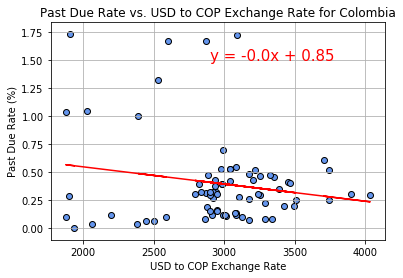

In [35]:
# Scatter plot
x_values = exc_pastdue_co_df['COP Exhange Rate']
y_values = exc_pastdue_co_df['Past Due Rate']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (2900, 1.50), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to COP Exchange Rate for Colombia')
plt.xlabel('USD to COP Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to GTQ Exchange Rate for Guatemala

In [36]:
guatemala_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'GUATEMALA')]
guatemala_extended_dataset_df = guatemala_df.groupby(['DATE'])
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
sum_past_due_gua = guatemala_extended_dataset_df['Past Due MLN'].sum()
total_net_gua = guatemala_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_gua = pd.DataFrame({
    "Total Past Due": sum_past_due_gua,
    "Total Net": total_net_gua,
    "Past Due Rate": (sum_past_due_gua / total_net_gua) * 100
    
})

exc_pastdue_gua_df = past_due_index_gua
exc_pastdue_gua_df.reset_index(level=0, inplace=True)
exc_pastdue_gua_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_gua_df['Date'] = exc_pastdue_gua_df['Date'].astype(str)
exc_pastdue_gua_df['Date'] = exc_pastdue_gua_df['Date'].str[:-3]

exc_pastdue_gua_df.head()

The correlation between both factors is -0.18


,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,2.03,1475.27,0.137602
1,2014-05,4.93,1586.63,0.310721
2,2014-06,3.44,1525.45,0.225507
3,2014-07,4.93,1597.91,0.308528
4,2014-08,4.94,1535.10,0.321803


In [37]:
# Merge both DataFrames
exc_pastdue_gua_df = exc_pastdue_gua_df.merge(exchange_rate_df)
exc_pastdue_gua_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,MXN Exhange Rate,CRC Exhange Rate,COP Exhange Rate,GTQ Exhange Rate
0,2014-04,2.03,1475.27,0.137602,13.08806,548.222400,1936.044992,7.732037
1,2014-05,4.93,1586.63,0.310721,12.85641,552.406904,1898.106683,7.778281
2,2014-06,3.44,1525.45,0.225507,12.97124,544.414998,1879.213333,7.775380
3,2014-07,4.93,1597.91,0.308528,13.19951,538.396306,1876.443325,7.810024
4,2014-08,4.94,1535.10,0.321803,13.07460,541.572005,1909.726659,7.787040


The correlation between both factors is 0.05
The r-squared is: 0.0024102393182791966


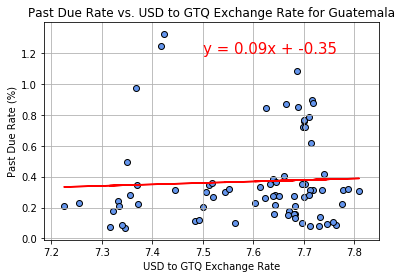

In [38]:
# Scatter plot
x_values = exc_pastdue_gua_df['GTQ Exhange Rate']
y_values = exc_pastdue_gua_df['Past Due Rate']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")

plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (7.5, 1.2), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to GTQ Exchange Rate for Guatemala')
plt.xlabel('USD to GTQ Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

## PRESIDENTS

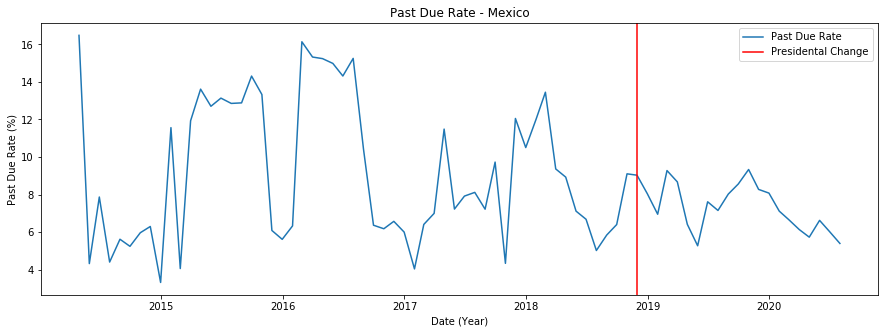

In [40]:
# Getting Presidents data
presidents_path = "datasets/presidents.xlsx"
presidents_df_1 = pd.read_excel(presidents_path)

#Rreturning data of Mexico from the extended_dataset
mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])

#Summary statistics
sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df["Net Investment MLN"].sum()

#Summary table
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
})

#Defining the x and y values and plot them
fig = plt.figure(figsize=(15,5))
y = past_due_index_mx['Past Due Rate']
x = past_due_index_mx.index
plt.title('Past Due Rate - Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)

#Returning data of Mexico from presidents_df
mexico_presidents_df = presidents_df_1.loc[presidents_df_1['Country'] == 'Mexico']
#print(mexico_presidents_df)

#Delete the 'Term End' column
del presidents_df_1['Term End']

#Making the 'Term Start' to a list
date_list = mexico_presidents_df['Term Start'].tolist()

#For loop in date_list to obtain the president change date
for p in range(len(date_list)-1):
        #print(date_list[p+1])
        date = str(date_list[p+1])
        year = int(str(date[0:4]))
        month = int(str(date[5:7]))
        day = int(str(date[8:10]))
        
        #Plot a line in the exact president change date
        plt.axvline(dt.datetime(year, month, day), color='red')        
plt.legend(["Past Due Rate", "Presidental Change"], loc ="upper right")

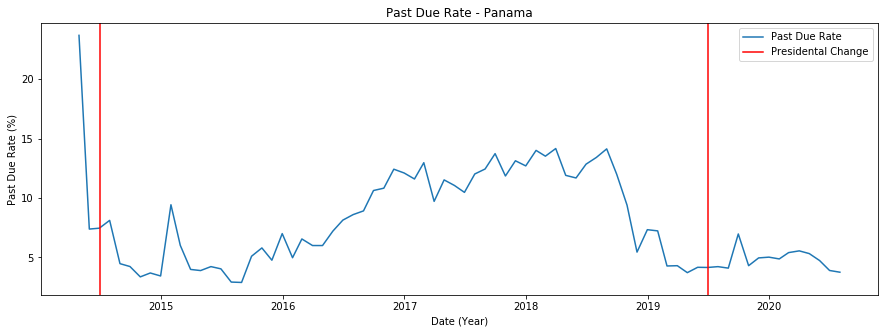

In [41]:
#Rreturning data of Panama from the extended_dataset
panama_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'PANAMA')]
panama_extended_dataset_df = panama_df.groupby(['DATE'])

#Summary statistics
sum_past_due_pa = panama_extended_dataset_df['Past Due MLN'].sum()
total_net_pa = panama_extended_dataset_df["Net Investment MLN"].sum()

#Summary table
past_due_index_pa = pd.DataFrame({
    "Total Past Due": sum_past_due_pa,
    "Total Net": total_net_pa,
    "Past Due Rate": (sum_past_due_pa / total_net_pa) * 100
    
})

#Defining the x and y values and plot them
fig = plt.figure(figsize=(15,5))
y = past_due_index_pa['Past Due Rate']
x = past_due_index_pa.index
plt.title('Past Due Rate - Panama')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)

#Returning data of Panama from presidents_df
panama_presidents_df = presidents_df_1.loc[presidents_df_1['Country'] == 'Panama']

#Making the 'Term Start' to a list
date_list = panama_presidents_df['Term Start'].tolist()

#For loop in date_list to obtain the president change date
for p in range(len(date_list)-1):
    date = str(date_list[p+1])
    year = int(str(date[0:4]))
    month = int(str(date[5:7]))
    day = int(str(date[8:10]))
    
    #Plot a line in the exact president change date
    plt.axvline(dt.datetime(year, month, day), color='red')
plt.legend(["Past Due Rate", "Presidental Change"], loc ="upper right")

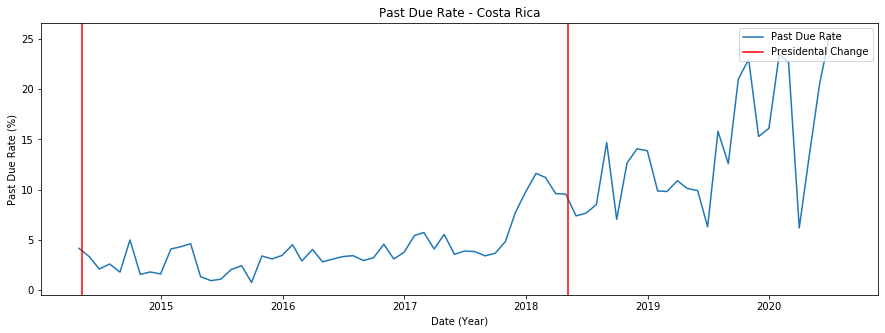

In [42]:
#Rreturning data of Panama from the extended_dataset
cr_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'COSTA RICA')]
cr_extended_dataset_df = cr_df.groupby(['DATE'])

#Summary statistics
sum_past_due_cr = cr_extended_dataset_df['Past Due MLN'].sum()
total_net_cr = cr_extended_dataset_df["Net Investment MLN"].sum()

#Summary table
past_due_index_cr = pd.DataFrame({
    "Total Past Due": sum_past_due_cr,
    "Total Net": total_net_cr,
    "Past Due Rate": (sum_past_due_cr / total_net_cr) * 100 
})

#Defining the x and y values and plot them
fig = plt.figure(figsize=(15,5))
y = past_due_index_cr['Past Due Rate']
x = past_due_index_cr.index
plt.title('Past Due Rate - Costa Rica')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)

#Returning data of Costa Rica from presidents_df
cr_presidents_df = presidents_df_1.loc[presidents_df_1['Country'] == 'Costa Rica']

#Making the 'Term Start' to a list
date_list = cr_presidents_df['Term Start'].tolist()

#For loop in date_list to obtain the president change date
for p in range(len(date_list)-1):
    date = str(date_list[p+1])
    year = int(str(date[0:4]))
    month = int(str(date[5:7]))
    day = int(str(date[8:10]))
    
    #Plot a line in the exact president change date
    plt.axvline(dt.datetime(year, month, day), color='red')
plt.legend(["Past Due Rate", "Presidental Change"], loc ="upper right")

In [43]:
past_due_index

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,212.32,1475.27,14.391942
1,2014-05,74.57,1586.63,4.699899
2,2014-06,94.45,1525.45,6.191616
3,2014-07,86.18,1597.91,5.393295
4,2014-08,105.76,1535.10,6.889453
...,...,...,...,...
71,2020-03,144.86,1144.26,12.659710
72,2020-04,148.14,1136.23,13.037853
73,2020-05,163.84,1159.34,14.132179
74,2020-06,158.56,1183.65,13.395852


In [44]:
#create new DF and take out index
boxplot_df = past_due_index 

boxplot_df.reset_index(level=0, inplace=True)

In [45]:
#create new column for year and put unique years into a list
boxplot_df["Year"] = pd.DatetimeIndex(boxplot_df['Date']).year

years_list = boxplot_df['Year'].unique()

years_list =  years_list.tolist()


In [46]:
# Put years into a list for for loop (and later for plot labels)

years_list

# Create empty list to fill with past due rate data

pd_rate_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for year in years_list:
    
    # Locate the rows which contain the specific year and get the past due rate
    pd_rate_year = boxplot_df['Past Due Rate'].loc[boxplot_df['Year'] == year]    
    
    # add subset 
    pd_rate_data.append(pd_rate_year)
    
    # Determine outliers using upper and lower bounds
    quartiles = pd_rate_year.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f"For {year} IQR is {iqr}")
    
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"For {year} values below {lower_bound} could be outliers")
    print(f"For {year} values above {upper_bound} could be outliers\n")
    

For 2014 IQR is 1.4917170617758355
For 2014 values below 2.462322934403052 could be outliers
For 2014 values above 8.429191181506393 could be outliers

For 2015 IQR is 2.6736691456884776
For 2015 values below 3.2688193265115713 could be outliers
For 2015 values above 13.96349590926548 could be outliers

For 2016 IQR is 4.786273204425812
For 2016 values below -1.4014984606672654 could be outliers
For 2016 values above 17.74359435703598 could be outliers

For 2017 IQR is 1.5789869115325228
For 2017 values below 3.2588845779284066 could be outliers
For 2017 values above 9.574832224058497 could be outliers

For 2018 IQR is 2.75161795201314
For 2018 values below 7.497899541893871 could be outliers
For 2018 values above 18.50437134994643 could be outliers

For 2019 IQR is 1.538311165190816
For 2019 values below 9.534703581534428 could be outliers
For 2019 values above 15.687948242297692 could be outliers

For 2020 IQR is 0.6603402710479696
For 2020 values below 12.002187540452326 could be ou

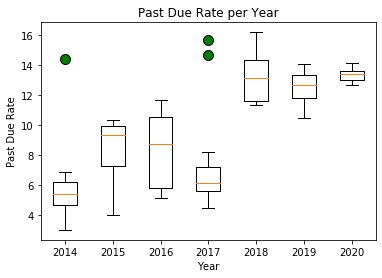

In [47]:
# Generate a box plot of the Past Due Rate across the years
flierprops = dict(marker='o', markerfacecolor='green', markersize=10, linestyle='none')

fig, ax = plt.subplots()
ax.set_title("Past Due Rate per Year")
ax.set_ylabel("Past Due Rate")
ax.set_xlabel("Year")
ax.boxplot(pd_rate_data, flierprops=flierprops)
ax.set_xticklabels(years_list)
plt.show()

In [48]:
# Define dataframes for before and after presidential change
pdi_pa_bf_cor = past_due_index_pa.loc[((past_due_index_pa.index > '2018-07-29') & (past_due_index_pa.index < '2019-07-01'))]
pdi_pa_af_cor = past_due_index_pa.loc[((past_due_index_pa.index > '2019-07-01') & (past_due_index_pa.index < '2020-07-01'))]

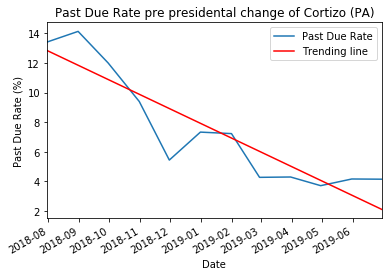

In [50]:
x_values = pdi_pa_bf_cor.index
y_values = pdi_pa_bf_cor['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2018, 7, 31), dt.date(2019, 6, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate pre presidental change of Cortizo (PA)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")

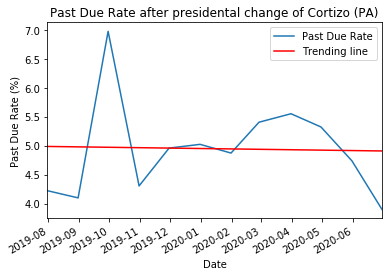

In [52]:
x_values = pdi_pa_af_cor.index
y_values = pdi_pa_af_cor['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2019, 7, 31), dt.date(2020, 6, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate after presidental change of Cortizo (PA)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")

In [53]:
# Define dataframes for before and after presidential change
pdi_mx_bf_lop = past_due_index_mx.loc[((past_due_index_mx.index > '2017-12-01') & (past_due_index_mx.index < '2018-12-01'))]
pdi_mx_af_lop = past_due_index_mx.loc[((past_due_index_mx.index > '2018-12-01') & (past_due_index_mx.index < '2019-12-01'))]

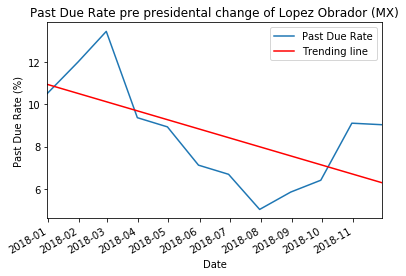

In [54]:
x_values = pdi_mx_bf_lop.index
y_values = pdi_mx_bf_lop['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2017, 12, 31), dt.date(2018, 11, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate pre presidental change of Lopez Obrador (MX)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")

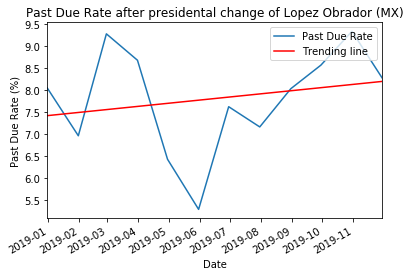

In [55]:
x_values = pdi_mx_af_lop.index
y_values = pdi_mx_af_lop['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2018, 12, 31), dt.date(2019, 11, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate after presidental change of Lopez Obrador (MX)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")

In [56]:
# Define dataframes for before and after presidential change
pdi_cr_bf_alv = past_due_index_cr.loc[((past_due_index_cr.index > '2017-05-08') & (past_due_index_cr.index < '2018-05-08'))]
pdi_cr_af_alv = past_due_index_cr.loc[((past_due_index_cr.index > '2018-05-08') & (past_due_index_cr.index < '2019-05-08'))]

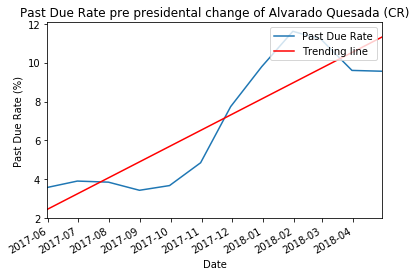

In [57]:
x_values = pdi_cr_bf_alv.index
y_values = pdi_cr_bf_alv['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2017, 5, 31), dt.date(2018, 4, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate pre presidental change of Alvarado Quesada (CR)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")

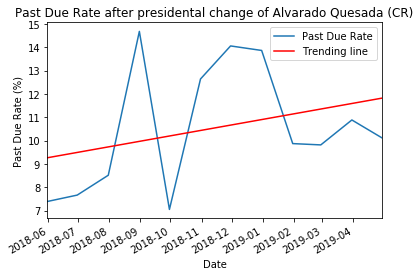

In [58]:
x_values = pdi_cr_af_alv.index
y_values = pdi_cr_af_alv['Past Due Rate']

fig, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)
ax.set_xlim([dt.date(2018, 5, 31), dt.date(2019, 4, 30)])

# To perform the linear regression we need the dates to be numeric
x_values = x_values.map(dt.date.toordinal)
# Perform linear regression
slope, y0, r, p, stderr = stats.linregress(x_values,
                                           y_values)

# x co-ordinates for the start and end of the line
x_endpoints = pd.DataFrame([x_values[0], x_values[-1]])

# Compute predicted values from linear regression
y_endpoints = y0 + slope * x_endpoints
# Overlay the line
ax.plot(x_endpoints, y_endpoints, c='r')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Past Due Rate (%)')
ax.set_title('Past Due Rate after presidental change of Alvarado Quesada (CR)')
plt.legend(["Past Due Rate", "Trending line"], loc ="upper right")